# Sprint5課題 機械学習スクラッチSVM

## ＜データ読込＞

### ＜シンプルデータセット1＞

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))
X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)
random_index = np.random.permutation(np.arange(n_samples))

X = X[random_index]
y = y[random_index].reshape(-1,1)

ds_simple1={}

ds_simple1["X"] = X
ds_simple1["y"] = y

ds_X_train, ds_X_test, ds_y_train, ds_y_test = train_test_split(ds_simple1["X"], ds_simple1["y"], test_size=0.25)

In [2]:
class ScratchSVMClassifier():
    """
    SVM分類器のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（polly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue
    gamma : float
      多項式カーネルのガンマ      

    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル

    """
    def __init__(self, num_iter, lr, kernel='linear', threshold=1e-5, gamma = 0.1, theta_zero = 0, dim = 1, verbose=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose   
        self.lam = 0
        self.lam_sv = 0
        self.sv_cnt = []
        self.X_sv = 0
        self.y_sv = 0
        self.gamma = gamma
        self.theta_zero = theta_zero
        self.dim = dim
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        SVM分類器を学習する。検証データが入力された場合はそれに対する精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        # numpyの表示を少数化
        np.set_printoptions(precision=8, suppress=True)
        
        # yを2次元化
        y = y.reshape(-1,1)
        
        # λを初期化
        self.lam = np.random.randn(X.shape[0])     
        self.lam = self.lam.reshape(-1,1)

        # サポートベクタX_sv、y_svを初期化
        X_sv = X
        y_sv = y
        
        for i in range(self.iter):
            # 最急降下法
            self.lam = self._gradient_descent(X, y)  
            
            sv_work = self.lam[self.lam > self.threshold]
            
            if self.verbose == True:
                print("〇〇〇学習データ{}回目：サポートベクトル数 = {}".format(i+1, sv_work.shape[0]))
                
            self.sv_cnt.append(sv_work.shape[0])
        
        # 閾値をセット
        self.index_support_vectors = np.where(self.lam.flatten() > self.threshold)
        self.n_support_vectors = len(self.index_support_vectors)
        
        # サポートベクトルを抽出
        self.lam_sv = self.lam[self.index_support_vectors].reshape(-1,1)
        self.X_sv = X[self.index_support_vectors].reshape(-1,2)
        self.y_sv = y[self.index_support_vectors].reshape(-1,1)
        

        # 推定            
        y_pred = self.predict(X)

    
    def kernel_func(self, Xi, Xj):
        #print("<<kernel_func>>")

        if self.kernel == 'linear':
            ret_kernel = np.dot(Xi,  Xj.T)  
            
        elif self.kernel == 'poly':
            gamma = self.gamma
            theta_zero = self.theta_zero
            dim = self.dim
            ret_kernel = (gamma * np.dot(Xi,  Xj.T) + theta_zero)**dim
        return ret_kernel
    
    
    def _gradient_descent(self, X, y ):
        #print("<<_gradient_descent>>")
        """
        最急降下法を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ
        error : 計算した誤差

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果

        """

        self.lam += self.lr * (1 - np.dot((np.dot(y, y.T) * self.kernel_func(X, X)), self.lam) )
        
        # ０未満の場合は０へクリップ
        self.lam[self.lam < 0] = 0
        
        return self.lam    
    
    
    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """

        # y_predの初期化
        y_pred = np.zeros(X.shape[0])
        y_pred = y_pred.reshape([-1,1])
        
        # 推定
        y_pred = np.dot(self.kernel_func(X, self.X_sv), (self.lam_sv * self.y_sv))
        
        # ０未満はー１へそれ以外は１
        y_pred = np.where(y_pred < 0, -1, 1)
        
        # 次元調整        
        y_pred = y_pred.reshape(-1,1)
        
        return y_pred


## 【問題1】ラグランジュの未定乗数法による最急降下

```python
    def _gradient_descent(self, X, y ):
        #print("<<_gradient_descent>>")
        """
        最急降下法を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ
        error : 計算した誤差

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果

        """

        self.lam += self.lr * (1 - np.dot((np.dot(y, y.T) * self.kernel_func(X, X)), self.lam) )
        
        # ０未満の場合は０へクリップ
        self.lam[self.lam < 0] = 0
        
        return self.lam  
```

## 【問題2】サポートベクターの決定

```python
        # yを2次元化
        y = y.reshape(-1,1)
        
        # λを初期化
        self.lam = np.random.randn(X.shape[0])     
        self.lam = self.lam.reshape(-1,1)

        # サポートベクタX_sv、y_svを初期化
        X_sv = X
        y_sv = y
        
        for i in range(self.iter):
            # 最急降下法
            self.lam = self._gradient_descent(X, y)  
            
            sv_work = self.lam[self.lam > self.threshold]
            
            if self.verbose == True:
                print("〇〇〇学習データ{}回目：サポートベクトル数 = {}".format(i+1, sv_work.shape[0]))
                
            self.sv_cnt.append(sv_work.shape[0])
        
        # 閾値をセット
        self.index_support_vectors = np.where(self.lam.flatten() > self.threshold)
        self.n_support_vectors = len(self.index_support_vectors)
        
        # サポートベクトルを抽出
        self.lam_sv = self.lam[self.index_support_vectors].reshape(-1,1)
        self.X_sv = X[self.index_support_vectors].reshape(-1,2)
        self.y_sv = y[self.index_support_vectors].reshape(-1,1)
        

```

## 【問題3】推定

```python
    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """

        # y_predの初期化
        y_pred = np.zeros(X.shape[0])
        y_pred = y_pred.reshape([-1,1])
        
        # 推定
        y_pred = np.dot(self.kernel_func(X, self.X_sv), (self.lam_sv * self.y_sv))
        
        # ０未満はー１へそれ以外は１
        y_pred = np.where(y_pred < 0, -1, 1)
        
        # 次元調整        
        y_pred = y_pred.reshape(-1,1)
        
        return y_pred

```

## 【問題4】学習と推定

In [ ]:
ScratchSVM = ScratchSVMClassifier(num_iter = 1000, lr = 0.001, threshold=1e-5, verbose = True)

# 学習開始
ScratchSVM.fit(ds_X_train, ds_y_train)

In [4]:
import pandas as pd
from sklearn.metrics import classification_report
y_pred_SVM = ScratchSVM.predict(ds_X_test)

# 評価
cr_SVM = classification_report(ds_y_test, y_pred_SVM, output_dict=True)

# pandas.DataFrameへ変換
df_cr_SVM = pd.DataFrame(cr_SVM)
display(df_cr_SVM)

,-1,1,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0
support,62.0,63.0,1.0,125.0,125.0


### scikit-learnと比較

In [5]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# SVM
model_SVC = SVC(kernel = "linear")

# 学習
clf = model_SVC.fit(ds_X_train, ds_y_train.flatten())

# 推定
y_pred_SVM = model_SVC.predict(ds_X_test)
print("y_pred_SVM = \n{}".format(y_pred_SVM))
print("y_pred_SVM.shape = {}".format(y_pred_SVM.shape))

# 評価
cr_SVN = classification_report(ds_y_test, y_pred_SVM, output_dict=True)

# pandas.DataFrameへ変換
df_cr_SVN = pd.DataFrame(cr_SVN)
display(df_cr_SVN)


y_pred_SVM = 
[-1  1 -1  1 -1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1 -1  1 -1 -1 -1  1 -1 -1
 -1  1 -1  1  1  1  1  1 -1  1 -1  1 -1  1  1  1 -1 -1  1  1 -1  1 -1 -1
 -1 -1 -1  1  1  1 -1  1 -1  1  1 -1 -1 -1 -1  1 -1  1  1 -1 -1  1  1  1
  1 -1  1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1 -1  1  1 -1 -1  1 -1
  1 -1  1  1  1 -1  1  1  1 -1  1  1  1  1 -1 -1 -1 -1  1  1  1  1 -1 -1
  1  1  1  1 -1]
y_pred_SVM.shape = (125,)


,-1,1,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0
support,62.0,63.0,1.0,125.0,125.0


### サポートベクタ―数の変移をグラフ化してみる

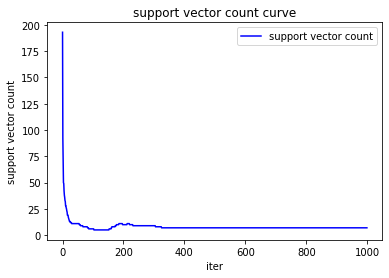

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.plot(range(len(ScratchSVM.sv_cnt)), ScratchSVM.sv_cnt, color='blue', label='support vector count')
plt.xlabel("iter")
plt.ylabel("support vector count")
plt.title("support vector count curve")
plt.legend()
plt.show()

## 【問題5】決定領域の可視化

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, sv_index, sv_index_name = "support vector", step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    sv_index : ndarray, shape(n_samples, 1)
        サポートベクタのインデックス
    sv_index_name : str
        サポートベクタのラベル名
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    plt.scatter(X[sv_index, 0], X[sv_index, 1], s=80, color="yellow", label=sv_index_name, marker='o')
    
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

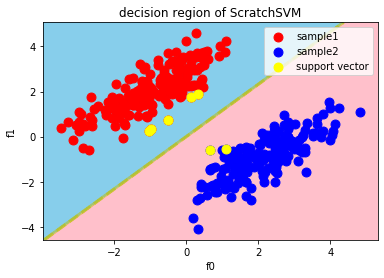

In [8]:
# 可視化
target_names = ['sample1','sample2']
decision_region(ds_X_train, ds_y_train.flatten(), ScratchSVM, sv_index = ScratchSVM.index_support_vectors, target_names = target_names, title='decision region of ScratchSVM', xlabel='f0', ylabel='f1')

### scikit-learnと比較-----------------------------------------------------------------------------------------------------------

In [9]:
model_SVC.support_

array([335, 112, 167])

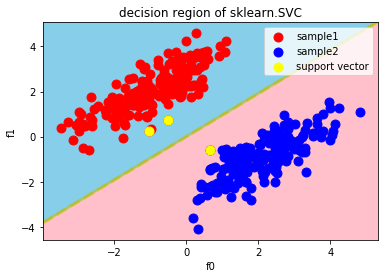

In [10]:
# 可視化
target_names = ['sample1','sample2']
decision_region(ds_X_train, ds_y_train.flatten(), model_SVC, sv_index = model_SVC.support_, target_names = target_names, title='decision region of sklearn.SVC', xlabel='f0', ylabel='f1')

## 【問題6】（アドバンス課題）多項式カーネル関数の作成

In [ ]:
ScratchSVMpoly = ScratchSVMClassifier(num_iter = 1000, lr = 0.001, kernel = "poly", threshold=1e-5, gamma = 0.4, theta_zero = 0.8, dim = 3, verbose = True)

# 学習開始
ScratchSVMpoly.fit(ds_X_train, ds_y_train)

### サポートベクタ―数の変移をグラフ化してみる

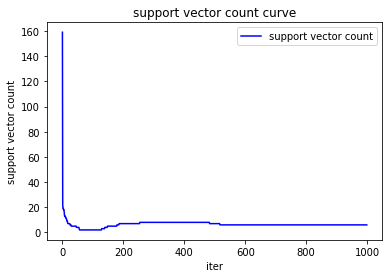

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(ScratchSVMpoly.sv_cnt)), ScratchSVMpoly.sv_cnt, color='blue', label='support vector count')
plt.xlabel("iter")
plt.ylabel("support vector count")
plt.title("support vector count curve")
plt.legend()
plt.show()

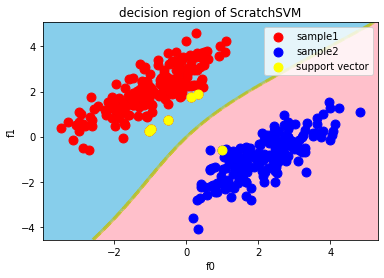

In [13]:
# 可視化
target_names = ['sample1','sample2']
decision_region(ds_X_train, ds_y_train.flatten(), ScratchSVMpoly, sv_index = ScratchSVMpoly.index_support_vectors, target_names = target_names, title='decision region of ScratchSVM', xlabel='f0', ylabel='f1')

上図のように非線形の分離が可能である。